In [3]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys

In [4]:
# Load the data from the Excel file
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\Dairy\Merged_data.xlsx'
df = pd.read_excel(file_path, header=0 )
df.index = df['Date']

In [5]:
# Define the function to create seasonal dummy variables
def SeasonalDummies(df, frequency='M'):
    nT = len(df)  # Number of observations
    startdate = df.index[0]  # Start date of the time series
    datetime = pd.DataFrame(data=pd.date_range(startdate, periods=nT, freq=frequency), columns=["datetime"])
    monthnumber = datetime["datetime"].dt.month  # Extract month numbers
    monthname = pd.DataFrame()  # DataFrame to store month names
    
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]  # Assign month names based on month numbers
    
    seasdum = pd.get_dummies(monthname)  # Create dummy variables for each month
    seasdum = seasdum.drop('D_January', axis=1)  # Drop January to avoid multicollinearity
    seasdum = seasdum.set_index(df.index)  # Set the index to match the original DataFrame
    seasdum = seasdum.astype(int)
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

# Combine the data with the seasonal dummy variables
df_with_dummies = pd.concat([df, seasdum], axis=1)


In [6]:
import itertools
import statsmodels.api as sm

# Define the function to perform the Zivot-Andrews test with seasonal dummies
def za_test(y, seasdum, max_lag=12, num_breaks=1):
    nT = len(y)
    m = 4  # Minimum distance between breaks
    h = int(nT * 0.15)  # Minimum distance from the start and end

    #set the test outputs
    best_t_stat = float('inf')
    best_breaks = None
    unit_root_stat = None 
    
    # Generate all possible combinations of break points
    potential_breaks = range(h, nT - h)
    all_combinations = list(itertools.combinations(potential_breaks, num_breaks))
    
    for breaks in all_combinations:
        if all(abs(breaks[i] - breaks[i-1]) >= m for i in range(1, num_breaks)):
            X = seasdum.copy()
            for i, bp in enumerate(breaks):
                X[f'break_{i}'] = (np.arange(nT) >= bp).astype(int) #break in levels
                X[f'break_trend_{i}'] = X[f'break_{i}'] * np.arange(nT)  #break in trend
            X['const'] = 1 #constat term
            X['trend'] = np.arange(nT)
            
            # Add lagged differences
            for lag in range(1, max_lag + 1):
                X[f'lag_{lag}'] = y.diff(lag).shift(lag)
            
            # Drop rows with NaN values
            X = X.dropna()
            y_valid = y[X.index]
            
            # Ensure all columns in X are numeric
            X = X.apply(pd.to_numeric, errors='coerce')
            
            # Fit the model
            model = sm.OLS(y_valid, X).fit()
            t_stat = min(abs(model.tvalues[f'break_{i}']) for i in range(num_breaks))
            ur_stat = model.tvalues.iloc[1]  # t-statistic for the lagged level term (usually the second parameter)
            
            if abs(t_stat) < abs(best_t_stat):
                best_t_stat = t_stat
                best_breaks = breaks
                unit_root_stat = ur_stat
                
    return best_breaks, best_t_stat, unit_root_stat

# Example usage
for column in ['API', 'PPI', 'CPI', 'Oil', 'Silage_PI', 'Dairy_Conce', 'CWage_20']:
    print(f"\nZivot-Andrews test for {column}:")
    break_points, t_stat, unit_root_stat = za_test(df_with_dummies[column], seasdum)

    
    print("Best break points:", [df_with_dummies.index[bp] for bp in break_points])
    print("T-statistic at best break points:", t_stat)
    print("Unit root test statistic:", unit_root_stat)



Zivot-Andrews test for API:
Best break points: [Timestamp('2012-06-01 00:00:00')]
T-statistic at best break points: 0.021571149087638682
Unit root test statistic: 1.8455960494029409

Zivot-Andrews test for PPI:
Best break points: [Timestamp('2014-04-01 00:00:00')]
T-statistic at best break points: 0.1686416449963916
Unit root test statistic: 0.3059125193773478

Zivot-Andrews test for CPI:
Best break points: [Timestamp('2012-03-01 00:00:00')]
T-statistic at best break points: 0.22763691786167342
Unit root test statistic: 1.9951940190041897

Zivot-Andrews test for Oil:
Best break points: [Timestamp('2012-11-01 00:00:00')]
T-statistic at best break points: 0.017134094384187403
Unit root test statistic: 0.35139233368613515

Zivot-Andrews test for Silage_PI:
Best break points: [Timestamp('2015-03-01 00:00:00')]
T-statistic at best break points: 0.11431413713734441
Unit root test statistic: 0.5522222397354627

Zivot-Andrews test for Dairy_Conce:
Best break points: [Timestamp('2016-01-01 00:


Analysis for API:
Lumsdaine-Papell best break points: [Timestamp('2012-06-01 00:00:00'), Timestamp('2017-01-01 00:00:00'), Timestamp('2021-04-01 00:00:00')]
T-statistic at best break points: 9.534599294479502e-06
Unit root test statistic: 2.811965016413432
Bai-Perron breakpoints: [Timestamp('2010-06-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2023-06-01 00:00:00')]
Similar breaks between methods: []


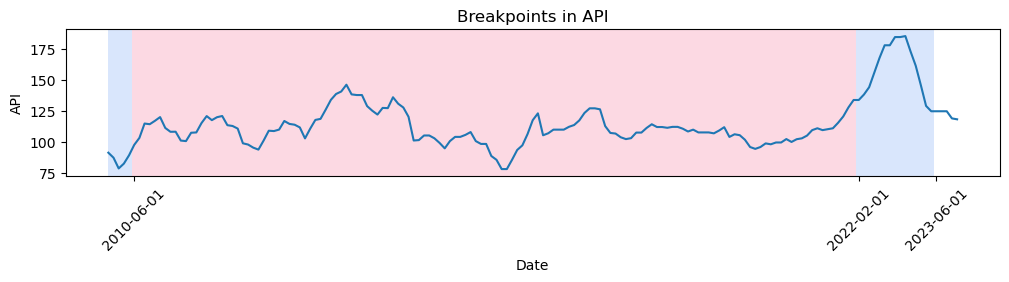


Analysis for CPI:


In [ ]:
import itertools
import statsmodels.api as sm
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

# Define the function to perform the Lumsdaine and Papell test with seasonal dummies
def lumsdaine_papell_with_seasonal_dummies(y, seasdum, max_lag=12, num_breaks=3):
    nT = len(y)
    m = 4  # Minimum distance between breaks
    h = int(nT * 0.15)  # Minimum distance from the start and end
    
    best_t_stat = float('inf')
    best_breaks = None
    unit_root_stat = None
    
    # Generate all possible combinations of break points
    potential_breaks = range(h, nT - h)
    all_combinations = list(itertools.combinations(potential_breaks, num_breaks))
    
    for breaks in all_combinations:
        if all(abs(breaks[i] - breaks[i-1]) >= m for i in range(1, num_breaks)):
            X = seasdum.copy()
            for i, bp in enumerate(breaks):
                X[f'break_{i}'] = (np.arange(nT) >= bp).astype(int) #break in levels
                X[f'break_trend_{i}'] = X[f'break_{i}'] * np.arange(nT)  #break in trend
            X['const'] = 1 #constant term
            X['trend'] = np.arange(nT)
            
            # Add lagged differences
            for lag in range(1, max_lag + 1):
                X[f'lag_{lag}'] = y.diff(lag).shift(lag)
            
            # Drop rows with NaN values
            X = X.dropna()
            y_valid = y[X.index]
            
            # Ensure all columns in X are numeric
            X = X.apply(pd.to_numeric, errors='coerce')
            
            # Fit the model
            model = sm.OLS(y_valid, X).fit()
            t_stat = min(abs(model.tvalues[f'break_{i}']) for i in range(num_breaks))
            ur_stat = model.tvalues.iloc[1]  # t-statistic for the lagged level term (usually the second parameter)
            
            if abs(t_stat) < abs(best_t_stat):
                best_t_stat = t_stat
                best_breaks = breaks
                unit_root_stat = ur_stat
                
    return best_breaks, best_t_stat, unit_root_stat

# Function to apply Bai-Perron test and find breakpoints
def bai_perron_breakpoints(y, n_bkps=3):
    ts = y.dropna()
    adjusted_index = ts.index
    ts_values = ts.values.reshape(-1, 1)
    
    # Apply the Bai-Perron test
    model = "l2"  # least squares
    algo = rpt.Binseg(model=model).fit(ts_values)
    
    result = algo.predict(n_bkps=n_bkps)
    
    # Convert breakpoint indices to dates
    break_dates = [adjusted_index[i] for i in result if i < len(adjusted_index)]
    
    return break_dates

# Function to identify similar breaks between the two methods
def find_similar_breaks(lumsdaine_breaks, bai_perron_breaks, tolerance=2):
    similar_breaks = []
    for lb in lumsdaine_breaks:
        for bp in bai_perron_breaks:
            if abs((lb - bp).days) <= tolerance:  # Compare the difference in days
                similar_breaks.append((lb, bp))
    return similar_breaks


# Example usage
for column in ['API', 'CPI', 'PPI', 'Dairy_Conce', 'CWage_20']:
    print(f"\nAnalysis for {column}:")
    
    # Lumsdaine and Papell test
    lumsdaine_breaks, t_stat, unit_root_stat = lumsdaine_papell_with_seasonal_dummies(df[column], seasdum)
    lumsdaine_breaks_dates = [df.index[bp] for bp in lumsdaine_breaks]
    
    print("Lumsdaine-Papell best break points:", lumsdaine_breaks_dates)
    print("T-statistic at best break points:", t_stat)
    print("Unit root test statistic:", unit_root_stat)
    
    # Bai-Perron test
    bai_perron_breaks = bai_perron_breakpoints(df[column])
    
    print("Bai-Perron breakpoints:", bai_perron_breaks)
    
    # Find similar breaks
    similar_breaks = find_similar_breaks(lumsdaine_breaks_dates, bai_perron_breaks)
    print("Similar breaks between methods:", similar_breaks)
    
    # Plot Bai-Perron breakpoints
    ts = df[column].dropna()
    adjusted_index = ts.index
    ts_values = ts.values.reshape(-1, 1)
    rpt.display(ts_values, [adjusted_index.get_loc(d) for d in bai_perron_breaks if d in adjusted_index])
    plt.title(f'Breakpoints in {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(ticks=[adjusted_index.get_loc(d) for d in bai_perron_breaks if d in adjusted_index], 
               labels=[d.strftime('%Y-%m-%d') for d in bai_perron_breaks], 
               rotation=45)
    plt.savefig(f'{column}_breakpoints.png', bbox_inches='tight')
    plt.show()
